# Keras - Plot History, Full Report and Grid Search

This notebook provides examples implementing the following

- Plot History : plot loss and accuracy from the history
- Full Report : print a full report and plot a confusion matrix
- Grid Search : uses the GridSearchCV and show how to resolve the issue relative to the multiclass models when using custom scoring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback, History

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

seed = 1000

## Functions definition

### Plot Keras History

Plot loss and accuracy for the training and validation set.

## Create a Full Multiclass Report

## Load Data

In [2]:
iris = datasets.load_iris()
x = iris.data
y = to_categorical(iris.target)
labels_names = iris.target_names
xid, yid = 0, 1

le = LabelEncoder()
encoded_labels = le.fit_transform(iris.target_names)

# plt.scatter(x[:,xid],x[:,yid],c=y,cmap=plt.cm.Set1,edgecolor='k')
# plt.xlabel(iris.feature_names[xid])
# plt.ylabel(iris.feature_names[yid])

## Split Train/Val/Test

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

In [31]:
def plot_history(train_loss, val_loss, train_acc, val_acc, modelName):
    
    if len(train_loss) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1, len(train_loss)+1)
    print(epochs)
    
    ## Loss
    plt.figure(1, figsize=(15,8))
    plt.plot(epochs, train_loss,'b-', lw=2.5, label=f'Training Loss: {train_loss[-1]:.4f}')
    plt.plot(epochs, val_loss,'g-',lw=2.5, label=f'Validation Loss: {val_loss[-1]:.4f}')
    plt.title(f'{modelName} Loss Graph', fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(f'{modelName}_Loss.svg')
    plt.close()
    
    ## Accuracy
    plt.figure(2, figsize=(15,8))
    plt.plot(epochs, train_acc,'b-',lw=2.5, label=f'Training Accuracy: {train_acc[-1]:.4f}')
    plt.plot(epochs, val_acc,'g-',lw=2.5, label=f'Validation Accuracy: {val_acc[-1]:.4f}')
    plt.title(f'{modelName} Accuracy Graph', fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(f'{modelName}_Accuracy.svg')
    plt.close()

In [32]:
class SLKerasUpdate(Callback):
    """Custom Keras callback that posts to Slack while training a neural network"""

    def __init__(self, modelName):
        #self.channel = channel_id
        #self.history = {}
        self.modelName = modelName

    def on_train_begin(self, logs={}):
        #report_stats(text=f'Training on {self.modelName} started at {datetime.now()}',channel=self.channel)

        self.train_acc = []
        self.valid_acc = []
        self.train_loss = []
        self.valid_loss = []
        self.n_epochs = 0

    def on_epoch_end(self, batch, logs={}):
        
        custom_logs = []
        
        for i in logs:
            custom_logs.append(logs[i])
        
        self.train_loss.append(custom_logs[0])
        self.train_acc.append(custom_logs[1])
        self.valid_loss.append(custom_logs[2])
        self.valid_acc.append(custom_logs[3])
        
        self.n_epochs += 1
        
        custom_logs = None

        message = f'Epoch: {self.n_epochs}, Training Loss: {self.train_loss[-1]:.4f}, Validation Loss: {self.valid_loss[-1]:.4f}'
        
        print(message)

        #report_stats(message, channel=self.channel)

    def on_train_end(self, logs={}):

        best_epoch = np.argmin(self.valid_loss)
        val_loss = self.valid_loss[best_epoch]
        train_loss = self.train_loss[best_epoch]
        train_acc = self.train_acc[best_epoch]
        val_acc = self.valid_acc[best_epoch]

        message = f'Trained for {self.n_epochs} epochs. Best epoch was {best_epoch + 1}.'
        print(message)
        #report_stats(message, channel=self.channel)

        message = f"Best validation loss = {val_loss:.4f}, Best Validation Accuracy = {100*val_acc:.2f}%"
        print(message)
        #report_stats(message, channel=self.channel)
        plot_history(self.train_loss, self.valid_loss, self.train_acc, self.valid_acc, self.modelName)

## Basic Keras Model

Create a very basic MLNN with a single Dense layer.

In [33]:
slack_update = SLKerasUpdate(modelName='SampleModel')

Epoch 1/3
6/6 [==============================] - 0s 27ms/step - loss: 1.2907 - acc: 0.2917 - val_loss: 1.2736 - val_acc: 0.3333
Epoch 2/3
6/6 [==============================] - 0s 3ms/step - loss: 1.2608 - acc: 0.2917 - val_loss: 1.2556 - val_acc: 0.3333
Epoch 3/3
6/6 [==============================] - 0s 3ms/step - loss: 1.2405 - acc: 0.2917 - val_loss: 1.2401 - val_acc: 0.3750
Trained for 3 epochs. Best epoch was 3.
Best validation loss = 1.2401, Best Validation Accuracy = 37.50%
range(1, 4)


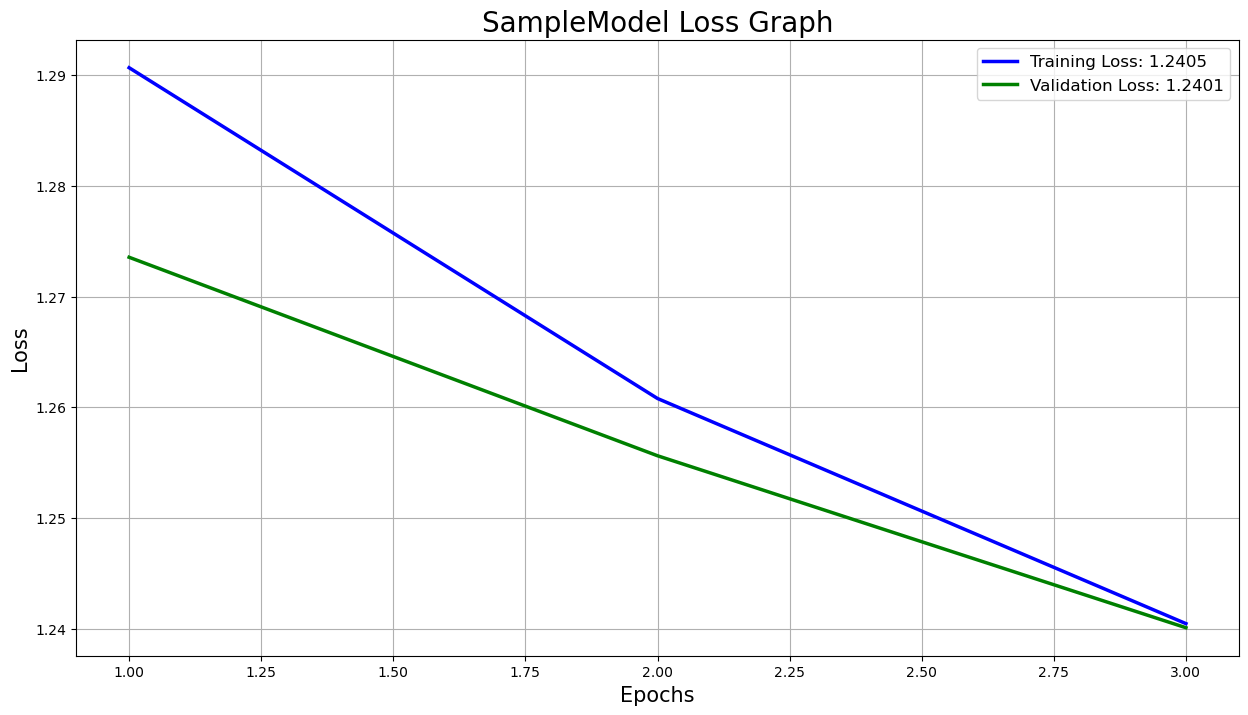

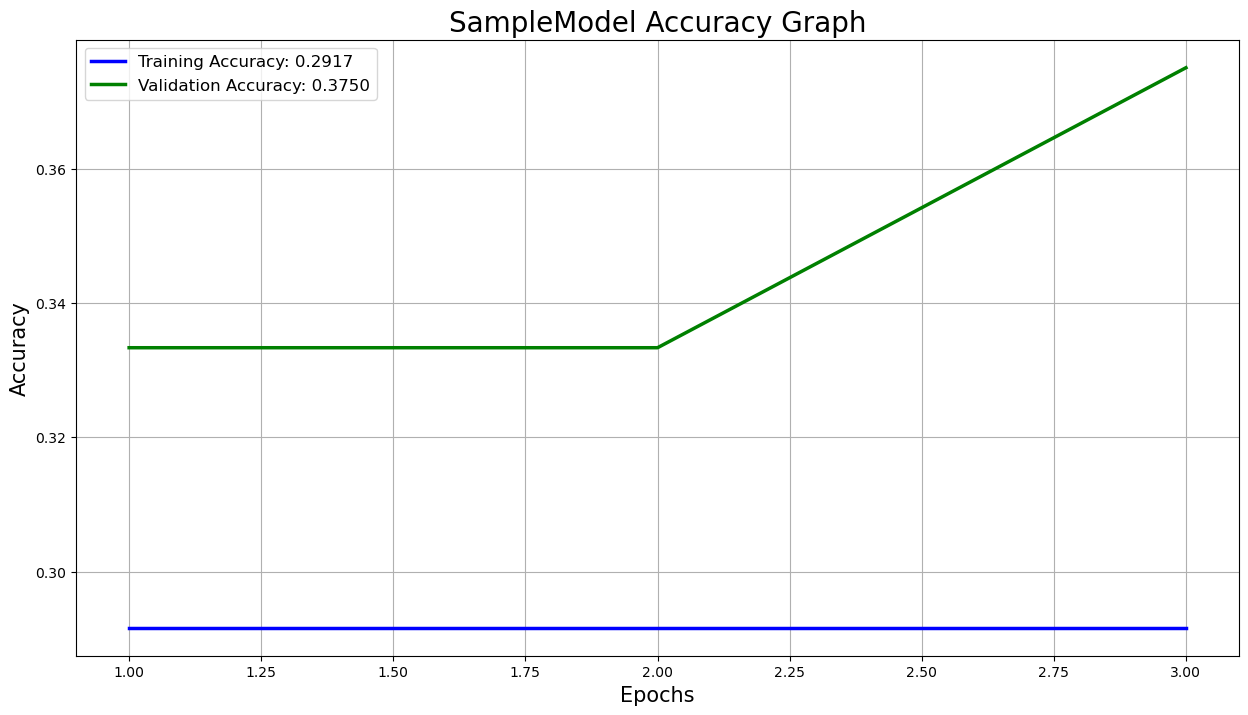

In [34]:
model = Sequential()
model.add(Dense(8,activation='relu',input_shape = (4,)))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, 
                    y_train,
                    epochs = 3,
                    batch_size = 16,
                    verbose=1,
                    validation_data=(x_val,y_val),
                   callbacks=[slack_update])